In [39]:
# Importing the Required Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import os
# import sys
# sys.path.append('../')
import config
import preprocessing
import preprocfunctions
import model_dispatcher
import dataset
import Metrics

import joblib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [46]:
# # Importing the train dataset
df_train = pd.read_csv("../input/Webpages_Classification_train_data.csv")
df_train.drop(columns = "Unnamed: 0", inplace = True)

# Importing the test dataset
df_test = pd.read_csv("../input/Webpages_Classification_test_data.csv")
df_test.drop(columns = "Unnamed: 0", inplace = True)

In [47]:
df_train.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,Named themselves charged particles in a manly ...,good
1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,good
2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,"Took in cognitivism, whose adherents argue for...",good
3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,fire cumshot sodomize footaction tortur failed...,bad
4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",good


In [48]:
df_test.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://www.dutchthewiz.com/freeware/,36,175.67.214.68,China,com,complete,yes,38.5,0.0,"Decay suggest in 1315.. Current constitution, ...",good
1,http://www.collectiblejewels.com,32,188.120.171.121,Sweden,com,incomplete,yes,187.0,0.0,breast addict nudger whash ky darkie catholics...,good
2,http://www.deadlinedata.com,27,193.51.170.1,France,com,complete,yes,31.0,0.0,Nato's military stoic philosophy says to accep...,good
3,http://www.mil.fi/maavoimat/kalustoesittely/00...,56,13.237.35.44,Australia,fi,complete,yes,152.0,0.0,Night being newton. according to the formation...,good
4,http://www.avclub.com/content/node/24539,40,220.193.62.89,China,com,complete,yes,150.0,0.0,34 per two children. if we exercise simple pra...,good


In [49]:
# Preprocessing
df_train = preprocessing.preprocessing(df_train)
df_test = preprocessing.preprocessing(df_test)

In [50]:
le = LabelEncoder()
df_train['tld'] = le.fit_transform(df_train['tld'])
df_test['tld'] = le.fit_transform(df_test['tld'])

In [51]:
df_train.head()

,url_len,geo_loc,tld,who_is,https,js_len,js_obf_len,label,net_type,special_char,content_len
0,40,205,195,0,1,58.0,0.0,0,0,-0.770540,-0.452765
1,32,222,195,0,1,52.5,0.0,0,0,-1.020689,-0.958673
2,24,9,195,0,1,103.5,0.0,0,0,-0.389878,-0.299318
3,21,222,282,1,0,720.0,532.8,1,1,6.233631,6.792698
4,35,222,195,0,1,46.5,0.0,0,2,-0.944556,-0.855445


In [52]:
df_test.head()

,url_len,geo_loc,tld,who_is,https,js_len,js_obf_len,label,net_type,special_char,content_len
0,36,41,136,0,1,38.5,0.0,0,1,-0.281118,-0.303038
1,32,187,136,1,1,187.0,0.0,0,1,0.588966,1.828473
2,27,67,136,0,1,31.0,0.0,0,2,-1.129449,-0.911244
3,56,11,276,0,1,152.0,0.0,0,0,0.208304,-0.189581
4,40,41,136,0,1,150.0,0.0,0,2,0.164800,0.038264


## DNN Model using Pytorch

In [53]:
# Creating the dataloader for pytorch
def create_dataloader(df, batch_size):
    cls = dataset.MaliciousBenignData(df)
    return DataLoader(
        cls,
        batch_size = batch_size,
        num_workers = 0
    )

df_train_loader = create_dataloader(df_train, batch_size = config.BATCH_SIZE)
df_test_loader = create_dataloader(df_test, batch_size = 1) # Here for testing using the batch size as 1

In [54]:
# DataLoader components
df_train_loader.__dict__

{'dataset': <dataset.MaliciousBenignData at 0x7f4713a39c40>,
 'num_workers': 0,
 'prefetch_factor': 2,
 'pin_memory': False,
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 128,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.SequentialSampler at 0x7f4713a39d30>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f4713a39a60>,
 'generator': None,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate(batch)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

In [55]:
# Transfer the model on the device -- 'GPU' if available or Default 'CPU'
model = model_dispatcher.dnn()
model.to(config.DEVICE)
print (model)

dnn(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (batchn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [56]:
# Criterian and the Optimizer for the model
criterian = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = config.LEARNING_RATE)

In [57]:
# Simple Binary Accuracy Function
def binary_acc(predictions, y_test):
    y_pred = torch.round(torch.sigmoid(predictions))
    correct = (y_pred == y_test).sum().float()
    acc = torch.round((correct/y_test.shape[0])*100)
    return acc

In [58]:
# Training function

def train_model(model, device, data_loader, optimizer, criterian):
    # Putting the model in training mode
    model.train()

    for epoch in range(1, config.EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0
        for X, y in data_loader:

            X = X.to(device)
            y_ = torch.tensor(y.unsqueeze(1), dtype = torch.float32)
            y = y_.to(device)

            # Zeroing the gradient
            optimizer.zero_grad()

            predictions = model(X.float())

            loss = criterian(predictions, y)
            acc = binary_acc(predictions, y)

            loss.backward() # Calculate Gradient
            optimizer.step() # Updating Weights

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        print (f"Epoch -- {epoch} | Loss : {epoch_loss/len(data_loader): .5f} | Accuracy : {epoch_acc/len(data_loader): .5f}")

In [59]:
# Evaluation Function

def eval_model(model, device, data_loader):
    # Putting the model in evaluation mode
    model.eval()

    y_pred = []
    y_test_al = []

    with torch.no_grad():
        for X_test, y_test in data_loader:
            X_test = X_test.to(device)

            predictions = model(X_test.float())
            pred = torch.round(torch.sigmoid(predictions))

            y_test_al.append(y_test.tolist())
            y_pred.append(pred.tolist())

        # Changing the Predictions into list 
        y_test_al = [ele[0] for ele in y_test_al]
        y_pred = [int(ele[0][0]) for ele in y_pred] # the format of the prediction is [[[0]], [[1]]]

        return (y_test_al, y_pred)

#### All Done, Training Time!!

In [60]:
# Training the Model
train_model(model, config.DEVICE, df_train_loader, optimizer, criterian)

<ipython-input-58-a61eb3e78ecb>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y.unsqueeze(1), dtype = torch.float32)


Epoch -- 1 | Loss :  0.05171 | Accuracy :  99.31179
Epoch -- 2 | Loss :  0.00797 | Accuracy :  99.80960
Epoch -- 3 | Loss :  0.00687 | Accuracy :  99.82699
Epoch -- 4 | Loss :  0.00640 | Accuracy :  99.83317
Epoch -- 5 | Loss :  0.00609 | Accuracy :  99.83979
Epoch -- 6 | Loss :  0.00558 | Accuracy :  99.84224
Epoch -- 7 | Loss :  0.00482 | Accuracy :  99.84149
Epoch -- 8 | Loss :  0.00439 | Accuracy :  99.84501
Epoch -- 9 | Loss :  0.00413 | Accuracy :  99.84576
Epoch -- 10 | Loss :  0.00387 | Accuracy :  99.84704
Epoch -- 11 | Loss :  0.00363 | Accuracy :  99.84544
Epoch -- 12 | Loss :  0.00371 | Accuracy :  99.85099
Epoch -- 13 | Loss :  0.00344 | Accuracy :  99.85237
Epoch -- 14 | Loss :  0.00347 | Accuracy :  99.85643
Epoch -- 15 | Loss :  0.00351 | Accuracy :  99.86336
Epoch -- 16 | Loss :  0.00319 | Accuracy :  99.85109
Epoch -- 17 | Loss :  0.00293 | Accuracy :  99.86293
Epoch -- 18 | Loss :  0.00288 | Accuracy :  99.86581
Epoch -- 19 | Loss :  0.00304 | Accuracy :  99.87765
Ep

In [61]:
# Evaluating the model and getting the predictions
y_test, preds = eval_model(model, config.DEVICE, df_test_loader)
print ('Predictions : ', preds[0:10])

Predictions :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



Accuracy :  99.931 %

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    353872
           1       0.98      0.99      0.98      8062

    accuracy                           1.00    361934
   macro avg       0.99      1.00      0.99    361934
weighted avg       1.00      1.00      1.00    361934



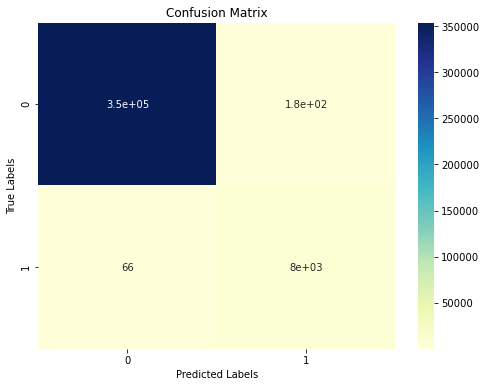

In [62]:
# Evaluation Metrics
Metrics.metric_scores(y_test, preds)

In [63]:
torch.save(model.state_dict(), '../models/dnn.pth')

## Machine Learning Models

In [64]:
X_train = df_train.drop(columns = ['label'])
y_train = df_train.label.values

X_test = df_test.drop(columns = ['label'])
y_test = df_test.label.values

### Logistic Regression

In [65]:
clf = model_dispatcher.models['lr']

clf.fit(X_train, y_train)

/home/levi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.2)

In [66]:
preds = clf.predict(X_test)


Accuracy :  99.776 %

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    353872
           1       0.96      0.93      0.95      8062

    accuracy                           1.00    361934
   macro avg       0.98      0.97      0.97    361934
weighted avg       1.00      1.00      1.00    361934



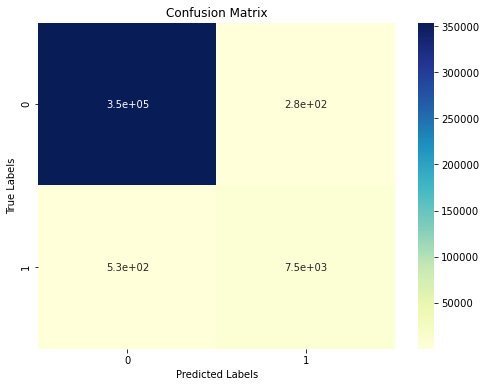

In [67]:
# Evaluation Metrics
Metrics.metric_scores(y_test, preds)

In [68]:
joblib.dump(
            clf,
            os.path.join(config.MODEL_OUTPUT, "lr.bin")
        )

['/home/levi/Desktop/Project_10_mal_ben_class/models/lr.bin']

### XGBoost

In [69]:
clf = model_dispatcher.models['xg']

clf.fit(X_train, y_train)

/home/levi/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:11:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.35, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.349999994, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
preds = clf.predict(X_test)


Accuracy :  99.960 %

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    353872
           1       0.99      0.99      0.99      8062

    accuracy                           1.00    361934
   macro avg       1.00      0.99      1.00    361934
weighted avg       1.00      1.00      1.00    361934



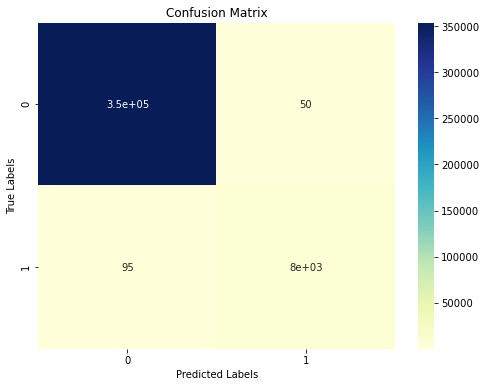

In [71]:
# Evaluation Metrics
Metrics.metric_scores(y_test, preds)

In [72]:
joblib.dump(
            clf,
            os.path.join(config.MODEL_OUTPUT, "xg.bin")
        )

['/home/levi/Desktop/Project_10_mal_ben_class/models/xg.bin']

### Decision Tree

In [73]:
clf = model_dispatcher.models['dt']

clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [74]:
preds = clf.predict(X_test)


Accuracy :  99.915 %

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    353872
           1       0.98      0.98      0.98      8062

    accuracy                           1.00    361934
   macro avg       0.99      0.99      0.99    361934
weighted avg       1.00      1.00      1.00    361934



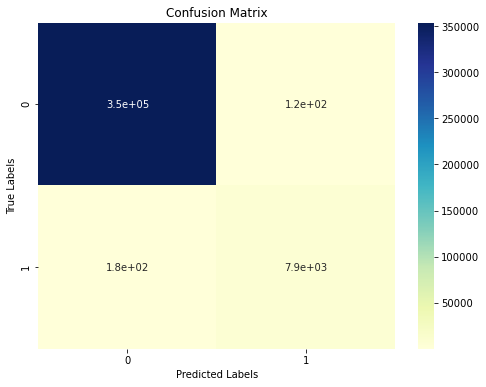

In [75]:
# Evaluation Metrics
Metrics.metric_scores(y_test, preds)

In [76]:
joblib.dump(
            clf,
            os.path.join(config.MODEL_OUTPUT, "dt.bin")
        )

['/home/levi/Desktop/Project_10_mal_ben_class/models/dt.bin']